### **Task 2 - Experimentation and uplift testing**

##### **background information**

You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.
___________________________________________________________

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

To get started use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store.

This can be broken down by:

* total sales revenue
* total number of customers
* average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store.



In [ ]:
## Libraries
# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Satistics
from statistics import stdev
from scipy.stats import t
import matplotlib.dates as mdates

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# import data csv
data = pd.read_csv("QVI_data.csv")
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [ ]:
## Data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [ ]:
# Chacking for nulls
data.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

The client selected store numbers 77, 86 and 88 as trial stores and and want control stores to be established
stores that are operational for the entire observation period.


##### **Select control stores**

In [ ]:
# create YEAR_MONTH feature
data["YEAR_MONTH"]=pd.to_datetime(data["DATE"]).dt.to_period("M")
data['YEAR_MONTH'].head()

0    2018-10
1    2018-09
2    2019-03
3    2019-03
4    2018-11
Name: YEAR_MONTH, dtype: period[M]

In [ ]:
# store total sales for each month
totSales = data.groupby(['STORE_NBR','YEAR_MONTH']).TOT_SALES.sum()
pd.DataFrame(totSales).head()

TOT_SALES
STORE_NBR YEAR_MONTH           
1         2018-07         206.9
          2018-08         176.1
          2018-09         278.8
          2018-10         188.1
          2018-11         192.6

In [ ]:
# store number of customers for each month
totCustomers = data.groupby(['STORE_NBR','YEAR_MONTH']).LYLTY_CARD_NBR.nunique()
pd.DataFrame(totCustomers).head()

LYLTY_CARD_NBR
STORE_NBR YEAR_MONTH                
1         2018-07                 49
          2018-08                 42
          2018-09                 59
          2018-10                 44
          2018-11                 46

In [ ]:
# Monthly store number of transaction per customer (unique txn id divided unique unique loyalty card number)
nTxnPerCust = data.groupby(['STORE_NBR','YEAR_MONTH']).TXN_ID.nunique()/data.groupby(['STORE_NBR','YEAR_MONTH']).LYLTY_CARD_NBR.nunique()
pd.DataFrame(nTxnPerCust).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.061224
          2018-08     1.023810
          2018-09     1.050847
          2018-10     1.022727
          2018-11     1.021739

In [ ]:
# Monthly store number of chips per Tansaction
nChipsPerTxn = data.groupby(['STORE_NBR','YEAR_MONTH']).PROD_QTY.sum()/data.groupby(['STORE_NBR','YEAR_MONTH']).TXN_ID.nunique()
pd.DataFrame(nChipsPerTxn).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.192308
          2018-08     1.255814
          2018-09     1.209677
          2018-10     1.288889
          2018-11     1.212766

In [ ]:
# Monthly store average price per unit
avgPrice = data.groupby(['STORE_NBR','YEAR_MONTH']).TOT_SALES.sum()/ data.groupby(['STORE_NBR','YEAR_MONTH']).PROD_QTY.sum()
pd.DataFrame(avgPrice).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     3.337097
          2018-08     3.261111
          2018-09     3.717333
          2018-10     3.243103
          2018-11     3.378947

In [ ]:
# Concatenate dataframe called 'measureOverTime

df = [totSales, totCustomers, nTxnPerCust, nChipsPerTxn, avgPrice]
measureOverTime = pd.concat(df, join = 'outer', axis = 1).reset_index()
# rename column
measureOverTime.rename(columns={'STORE_NBR': 'STORE_NBR','TOT_SALES':'totSales','LYLTY_CARD_NBR' :'nCustomers',0:'ntransPerCust',1 :'nChipsPerTXN',2:'avgPricePerUnit'},inplace=True)
measureOverTime.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947


In [ ]:
# we will remove the stores that did not record sales for the entire duration (12 months)
nMonth = data.groupby('STORE_NBR')['YEAR_MONTH'].nunique()
nMonth = nMonth[nMonth < 12]
nMonth

STORE_NBR
11      2
31      2
44     11
76      1
85      1
92      1
117    11
193     3
206     2
211     2
218    11
252     2
Name: YEAR_MONTH, dtype: int64

There are 12 stores with record sales less 12 month

In [ ]:
unrecorded_stores = nMonth.index.to_list()

In [ ]:
# drop unrecorded stores from 'measureOverTime'

measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(unrecorded_stores)]
measureOverTime

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3164,272,2019-02,395.5,45,1.066667,1.895833,4.346154
3165,272,2019-03,442.3,50,1.060000,1.905660,4.379208
3166,272,2019-04,445.1,54,1.018519,1.909091,4.239048
3167,272,2019-05,314.6,34,1.176471,1.775000,4.430986


In [ ]:
# create new dataframe that include pre-trial duration - before february 2019

preTrialData = measureOverTime.loc[measureOverTime['YEAR_MONTH']<"2019-02", :]
preTrialData

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,2018-09,304.7,32,1.125000,1.972222,4.291549
3160,272,2018-10,430.6,44,1.136364,1.980000,4.349495
3161,272,2018-11,376.2,41,1.097561,1.933333,4.324138
3162,272,2018-12,403.9,47,1.000000,1.893617,4.538202


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store

In [ ]:
# create a function to calculate correlation between trial store and each control store

def calculateCorrelation(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

In [ ]:
# Create another function which calculates a standardised magnitude difference

def calculateMagnitudeDistance(inputTable, metric, trial_store):
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index = True)
    return output

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

#### **1. Trial Store 77**

#### **a. Selecting Control store for Trial store 77**

In [ ]:
# calculating correlation between trial store 77 and other stores
trial_store = 77
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)

# calculating magnitude difference between trial store 77 and other stores
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)


In [ ]:
# Merge the scores together for total sales

score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)
score_nSales.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.075218,0.408163
1,77.0,2.0,-0.263079,0.590119
2,77.0,3.0,0.806644,0.522914
3,77.0,4.0,-0.263300,0.644934
4,77.0,5.0,-0.110652,0.516320


In [ ]:
# combined score composed of correlation and magnitude
# scoreNsales
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
77.0   1.0        0.075218   0.408163     0.241691
       2.0       -0.263079   0.590119     0.163520
       3.0        0.806644   0.522914     0.664779
       4.0       -0.263300   0.644934     0.190817
       5.0       -0.110652   0.516320     0.202834

In [ ]:
# Merge the scores together for customers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

# score customers
score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()


Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
77.0   1.0        0.322168   0.663866         0.493017
       2.0       -0.572051   0.471429        -0.050311
       3.0        0.834207   0.489796         0.662002
       4.0       -0.295639   0.498258         0.101310
       5.0        0.370659   0.512605         0.441632

In [ ]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head(3)


scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
77.0   233.0      0.697290         0.816607           0.756949
       71.0       0.789497         0.663123           0.726310
       84.0       0.656972         0.715000           0.685986

store 233 matches trial store 77 the most. so we can assume 233 as control store fot trial store 77.

**b. Check visualize the performance trial store 77 and selected control store 233 and other stores**

In [ ]:
control_store = 233

In [ ]:
pastdata = preTrialData
# Categorize data into trial store = 77, control store = 233 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i ==control_store:
        store_type.append('Control Store')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

store_type
Control Store      1
Other Stores     258
Trial Store        1
Name: STORE_NBR, dtype: int64

In [ ]:
pastdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1820 entries, 0 to 3163
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   STORE_NBR        1820 non-null   int64    
 1   YEAR_MONTH       1820 non-null   period[M]
 2   totSales         1820 non-null   float64  
 3   nCustomers       1820 non-null   int64    
 4   ntransPerCust    1820 non-null   float64  
 5   nChipsPerTXN     1820 non-null   float64  
 6   avgPricePerUnit  1820 non-null   float64  
 7   store_type       1820 non-null   object   
dtypes: float64(4), int64(2), object(1), period[M](1)
memory usage: 128.0+ KB


In [ ]:
# convert 'YEAR_MONTH' into date time and store to new column 'Transaction_Month'
pastdata['Transaction_Month'] = pd.to_datetime(pastdata['YEAR_MONTH'].astype(str))
pastdata['Transaction_Month'].head()

0   2018-07-01
1   2018-08-01
2   2018-09-01
3   2018-10-01
4   2018-11-01
Name: Transaction_Month, dtype: datetime64[ns]

In [ ]:
# Monthly tot sales for trial store 77
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 233
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
Transaction_Month,,,
2018-07-01,290.7,296.8,638.004651
2018-08-01,285.9,255.5,610.223450
2018-09-01,228.6,225.2,620.198450
2018-10-01,185.7,204.5,635.314729
2018-11-01,211.6,245.3,618.864341
2018-12-01,279.8,267.3,648.453876
2019-01-01,177.5,204.4,628.684496


In [ ]:
# Visualize 'nCustomers'
# monthly total customer for trial store 77
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 233
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,51,51,72.333333
2018-08-01,47,48,72.120155
2018-09-01,42,42,70.131783
2018-10-01,37,35,71.608527
2018-11-01,41,40,70.534884
2018-12-01,46,47,73.515504
2019-01-01,35,35,71.240310


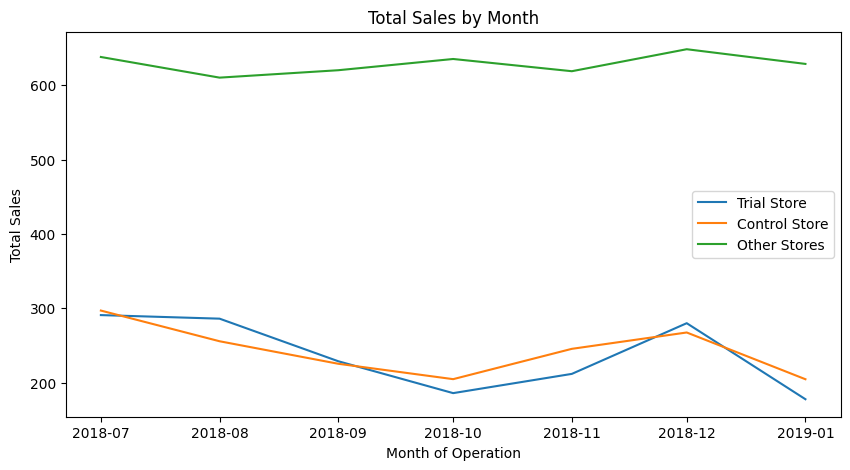

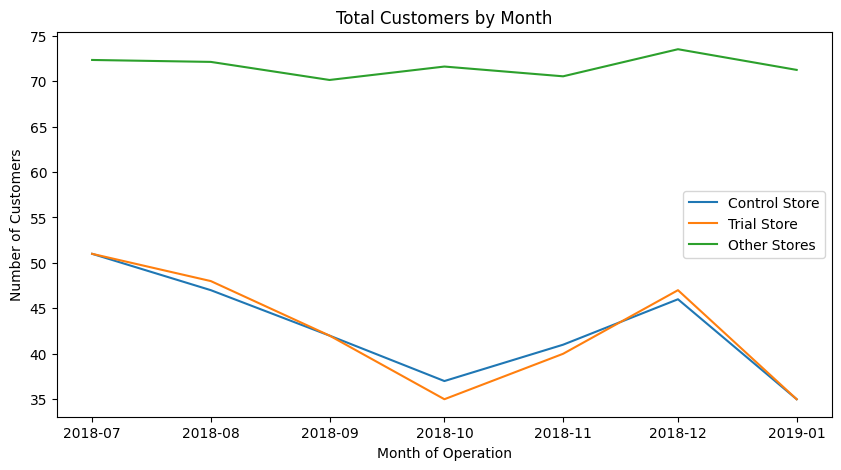

In [ ]:

# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)


 #### **c. Assestment for trial store 77**

In [ ]:
# define the trial store
trial_store = 77

# Filter pre trial data for control sales and trial sales
trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store', 'totSales'].sum()

# calculate the scaling factor for control sales
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.023617303289553

In [ ]:
# filtering data only for control store 233
scaledControlSales = measureOverTime
scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]

In [ ]:
# applies the 'scalingFactorSales' for control store

scaledControlSales['controlSales'] = scaledControlSales['totSales']*scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,controlSales
2699,233,2018-07,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,2018-08,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,2018-09,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,2018-10,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,2018-11,211.6,40,1.025000,1.512195,3.412903,216.597421


In [ ]:
# Create new dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH','controlSales']]
percentageDiff.reset_index(drop = True,inplace =True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] ==trial_store,'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales
0,2018-07,297.565550,296.8
1,2018-08,292.652187,255.5
2,2018-09,233.998916,225.2
3,2018-10,190.085733,204.5
4,2018-11,216.597421,245.3


In [ ]:
# Calculate percentage difference beetween control sales and trial sales

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales)/percentageDiff.controlSales
percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,297.565550,296.8,0.002573
1,2018-08,292.652187,255.5,0.126950
2,2018-09,233.998916,225.2,0.037602
3,2018-10,190.085733,204.5,0.075830
4,2018-11,216.597421,245.3,0.132516


In [ ]:
# Calculate the standar deviation based on the scaled percentage diff in pre trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.049940762641425364

In [ ]:
# Find the 95th percentile of the t distribution
# define the degrees of freedom (dof = 8-1 =7)
dof =7
t.isf(0.05, dof)


1.8945786050613054

We can see that

* march : t-value > t-distribution
* April : t-value > t-distribution
that means there is a difference between trial and control stores

In [ ]:
# Add a new column 'TransactionMonth' to 'scaledControlSales'

scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEAR_MONTH'].astype(str), format = '%Y-%m')

# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales.head()

,Control Sales
TransactionMonth,
2018-07-01,297.565550
2018-08-01,292.652187
2018-09-01,233.998916
2018-10-01,190.085733
2018-11-01,216.597421


In [ ]:
# Create a new column 'TransationMonth' which convert column 'YEAR_MONTH' into datetime

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEAR_MONTH'].astype(str), format = '%Y-%m')
measureOverTime.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [ ]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales.head()

,Trial Sales
TransactionMonth,
2018-07-01,296.8
2018-08-01,255.5
2018-09-01,225.2
2018-10-01,204.5
2018-11-01,245.3


In [ ]:
# Create two new columns df 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,297.565550,267.844249,327.286851,296.8
2018-08-01,292.652187,263.421640,321.882734,255.5
2018-09-01,233.998916,210.626747,257.371084,225.2
2018-10-01,190.085733,171.099680,209.071786,204.5
2018-11-01,216.597421,194.963341,238.231502,245.3
2018-12-01,286.408121,257.801241,315.015001,267.3
2019-01-01,181.692071,163.544390,199.839753,204.4
2019-02-01,249.762622,224.815950,274.709294,235.0
2019-03-01,203.802205,183.446130,224.158280,278.5


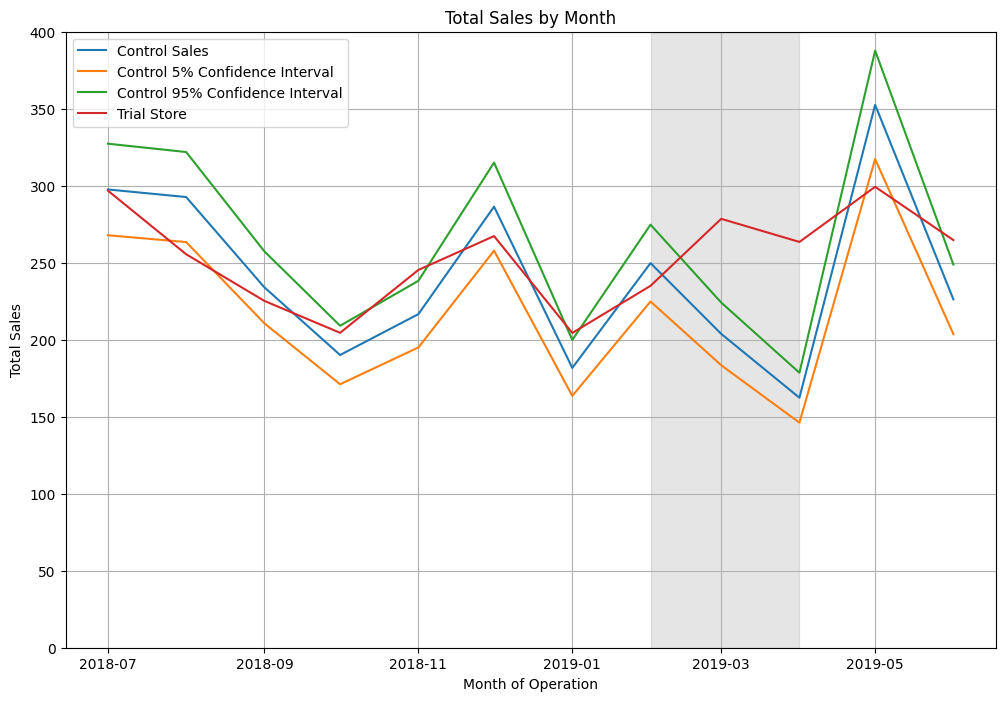

In [ ]:
# visualize 'combinesales' dataframe

plt.figure(figsize = (12, 8))
plt.plot(combineSales)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)
plt.ylim((0, 400))
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)
plt.grid()
plt.show()


its look like the trial store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in the two of 3 months trial period.

In [ ]:
# Now let's move on to 'nCustomers'
trial_customers = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type'] == 'Control Store', 'nCustomers'].sum()

# Calculate scaling factor
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0033557046979866

In [ ]:
# Filter data only for control store 233
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]

# Applies 'scalingFactorSales' to 'totSales' column
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
2699,233,2018-07,290.7,51,1.058824,1.629630,3.303409,2018-07-01,51.171141
2700,233,2018-08,285.9,48,1.041667,1.600000,3.573750,2018-08-01,48.161074
2701,233,2018-09,228.6,42,1.071429,1.555556,3.265714,2018-09-01,42.140940
2702,233,2018-10,185.7,35,1.028571,1.555556,3.316071,2018-10-01,35.117450
2703,233,2018-11,211.6,40,1.025000,1.512195,3.412903,2018-11-01,40.134228


In [ ]:
# Create percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH','controlCustomers']]
percentageDiff.reset_index(drop = True , inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True , inplace = True)
percentageDiff = pd.concat([percentageDiff,trialCustomers], axis =1)
percentageDiff.rename(columns = {'nCustomers':'trialCustomers'},inplace= True)

# Calculate persentage difference and put it in a new column
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers-percentageDiff.trialCustomers)/percentageDiff.controlCustomers
percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,51.171141,51,0.003344
1,2018-08,48.161074,47,0.024108
2,2018-09,42.140940,42,0.003344
3,2018-10,35.117450,37,0.053607
4,2018-11,40.134228,41,0.021572


In [ ]:
# Our null Hipothesis is such that the trial period is the same as pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH']<'2019-02','percentageDiff'])
stdDev

0.018240748558243945

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

7     0.183352
8    13.476388
9    30.778725
Name: tValue, dtype: float64

In [ ]:
# Find the 95th percentile of the t distribution with dof = 7
# Define the degrees of freeedom
# since we have 8 pre-trial months ,dof = 8 - 1 = 7
dof = 7

t.isf(0.05,7)

1.8945786050613054

The result show that:
* Feb   : t-value < t-distribution
* march : t-value > t-distribution
* April : t-value > t-distribution
that means there is a difference between trial and control stores customers

In [ ]:
# visualisation
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:,['TransactionMonth','controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers':'Control Customers'}, inplace = True)
controlCustomers.head()

,Control Customers
TransactionMonth,
2018-07-01,51.171141
2018-08-01,48.161074
2018-09-01,42.140940
2018-10-01,35.117450
2018-11-01,40.134228


In [ ]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store,['TransactionMonth','nCustomers']]
trialCustomers.set_index('TransactionMonth' , inplace =True)
trialCustomers.rename(columns = {'nCustomers':'Trial Customers'}, inplace = True)
trialCustomers.head()

,Trial Customers
TransactionMonth,
2018-07-01,51
2018-08-01,47
2018-09-01,42
2018-10-01,37
2018-11-01,41


In [ ]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers']*(1-stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers']*(1+stdDev*2)

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers,trialCustomers,left_index = True, right_index = True)
combineCustomers.head()

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,51.171141,49.304341,53.037941,51
2018-08-01,48.161074,46.404086,49.918062,47
2018-09-01,42.140940,40.603575,43.678304,42
2018-10-01,35.117450,33.836313,36.398587,37
2018-11-01,40.134228,38.670071,41.598385,41


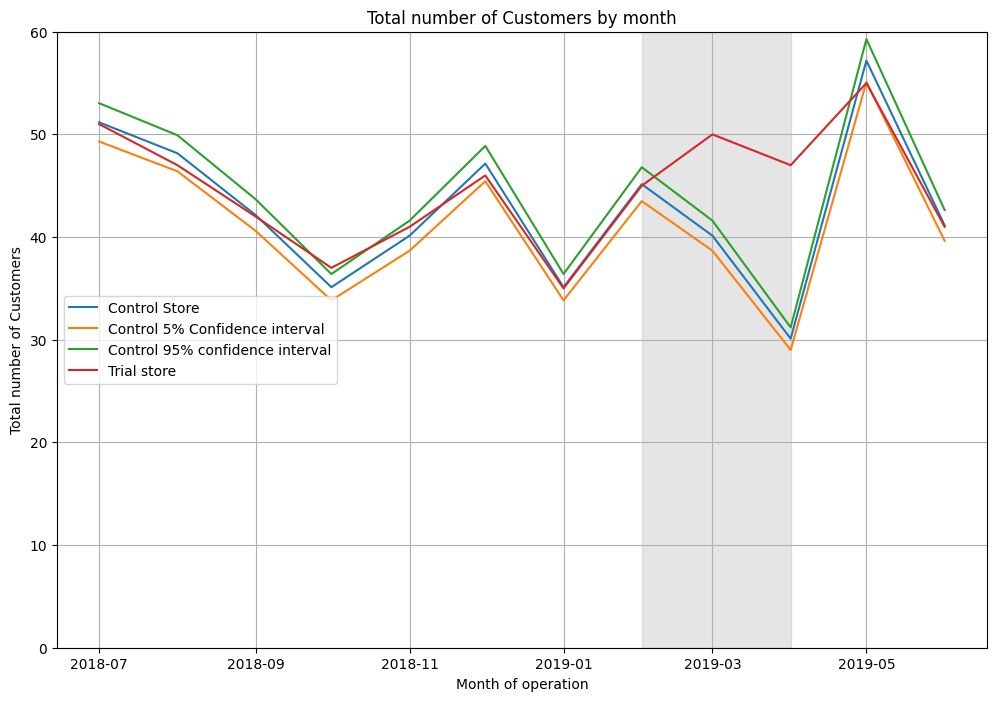

In [ ]:
# Let's plot the combineCuustomers

plt.figure(figsize = (12,8))
plt.plot(combineCustomers)
plt.title('Total number of Customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of Customers')
plt.legend(['Control Store','Control 5% Confidence interval','Control 95% confidence interval','Trial store'],loc = 6)
plt.ylim((0,60))
plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color = 'grey', alpha = 0.2)
plt.grid()
plt.show()



The visualization shows that total customers in trial store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in march and april which is 2 of 3 months trial period.



#### **2. Control store for Trial store 86**

In [ ]:
# calculating correlation and magnitude distance between trial store 86 and other stores
trial_store = 86

# for total sales
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)

# for nCustomers
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)

In [ ]:
# SCORE TOTAL SALES
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

# combined score  composed of correlation and magnitude
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
86.0   1.0        0.445632   0.488334     0.466983
       2.0       -0.403835   0.321131    -0.041352
       3.0       -0.261284   0.507515     0.123116
       4.0       -0.039035   0.635654     0.298309
       5.0        0.235159   0.579835     0.407497

In [ ]:
# SCORE CUSTOMERS

score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()

Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
86.0   1.0        0.485831   0.510204         0.498018
       2.0       -0.086161   0.428571         0.171205
       3.0       -0.353786   0.563025         0.104620
       4.0       -0.169608   0.537815         0.184103
       5.0       -0.253229   0.714286         0.230528

In [ ]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head(3)


scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
86.0   155.0      0.808106         0.733343           0.770724
       109.0      0.697120         0.742532           0.719826
       114.0      0.631393         0.663384           0.647389

store 155 matches trial store 86 the most. so we can assume 155 as control store fot trial store 86.

**b. Check visualize the performance trial store 86 and selected control store 155**

In [ ]:
control_store = 155

In [ ]:
pastdata = preTrialData

# Categorize data into trial store = 86, control store = 155 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i ==control_store:
        store_type.append('Control Store')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

store_type
Control Store      1
Other Stores     258
Trial Store        1
Name: STORE_NBR, dtype: int64

In [ ]:
# Monthly tot sales for trial store 86
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 155
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,892.20,924.6,633.239922
2018-08-01,764.05,782.7,606.326744
2018-09-01,914.60,1014.4,614.480620
2018-10-01,948.40,963.8,629.415504
2018-11-01,918.00,898.8,613.593411
2018-12-01,841.20,849.8,644.020155
2019-01-01,841.40,874.6,623.513566


In [ ]:
# Visualize 'nCustomers'
# monthly total customer for trial store 77
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 233
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,99,101,71.953488
2018-08-01,94,91,71.771318
2018-09-01,103,103,69.658915
2018-10-01,109,108,71.046512
2018-11-01,100,101,70.069767
2018-12-01,98,97,73.120155
2019-01-01,94,96,70.775194


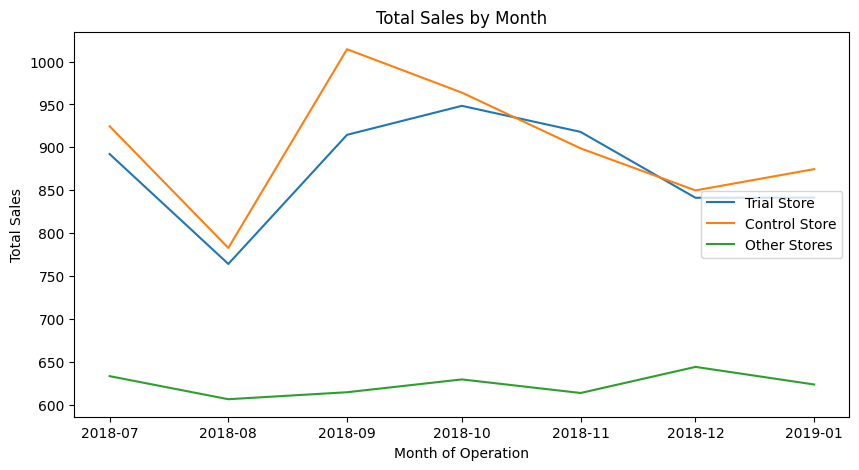

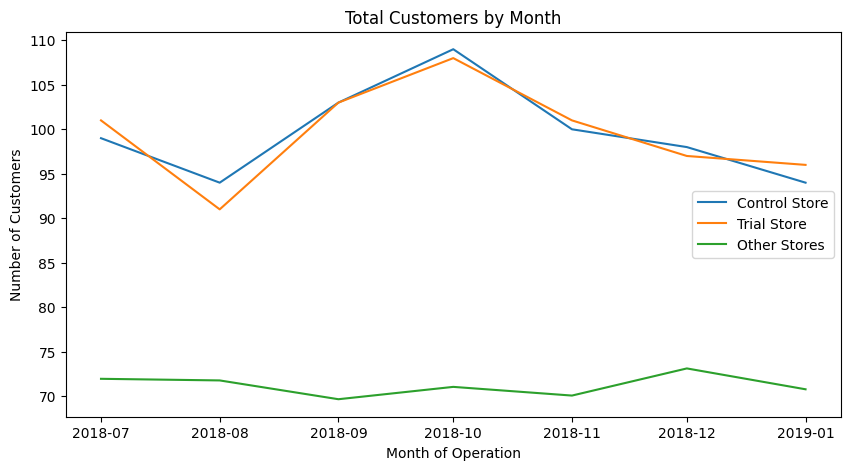

In [ ]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)


**c. Assesment for trial store 86**

In [ ]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for contrl store

trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store','totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store','totSales'].sum()
scalingFactorSales = trial_sum/control_sum
scalingFactorSales

0.9700651481287743

In [ ]:
scaledControlSales = measureOverTime
# set dataframe only for control store 155

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR']==control_store]
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [ ]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlSales
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01,934.948790
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01,871.894555


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

In [ ]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,896.922236,892.20,0.005265
1,2018-08,759.269991,764.05,0.006296
2,2018-09,984.034086,914.60,0.070561
3,2018-10,934.948790,948.40,0.014387
4,2018-11,871.894555,918.00,0.052880
5,2018-12,824.361363,841.20,0.020426
6,2019-01,848.418979,841.40,0.008273
7,2019-02,864.522060,913.20,0.056306
8,2019-03,780.320405,1026.80,0.315870
9,2019-04,819.317024,848.20,0.035253


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.02583395285477237

In [ ]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)

In [ ]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,892.20
2018-08-01,764.05
2018-09-01,914.60
2018-10-01,948.40
2018-11-01,918.00
2018-12-01,841.20
2019-01-01,841.40
2019-02-01,913.20
2019-03-01,1026.80


In [ ]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,896.922236,850.580142,943.264329
2018-08-01,759.269991,720.040101,798.499882
2018-09-01,984.034086,933.191106,1034.877067
2018-10-01,934.948790,886.641944,983.255636
2018-11-01,871.894555,826.845589,916.943521


In [ ]:
# Merge the two dataframes together 'controlSales' and 'trialSales'
combineSales = pd.merge(controlSales,trialSales,left_index = True, right_index =True )
combineSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,896.922236,850.580142,943.264329,892.20
2018-08-01,759.269991,720.040101,798.499882,764.05
2018-09-01,984.034086,933.191106,1034.877067,914.60
2018-10-01,934.948790,886.641944,983.255636,948.40
2018-11-01,871.894555,826.845589,916.943521,918.00


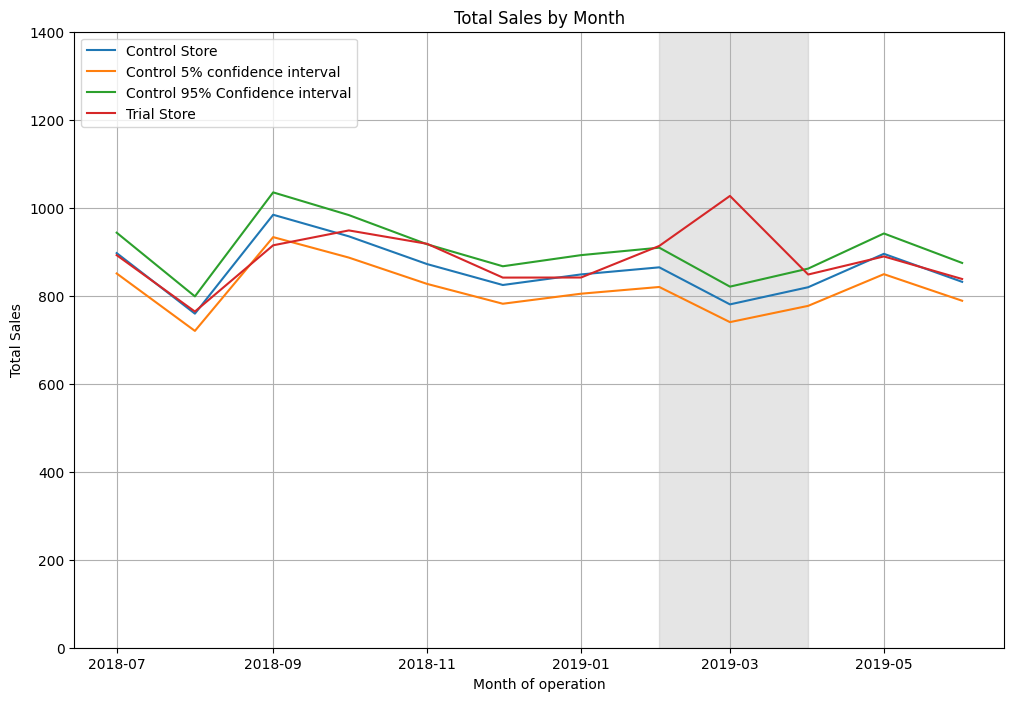

In [ ]:
plt.figure(figsize =(12,8))
plt.plot(combineSales)

plt.title('Total Sales by Month')
plt.xlabel('Month of operation')
plt.ylabel('Total Sales')

plt.legend(['Control Store','Control 5% confidence interval','Control 95% Confidence interval','Trial Store'],loc = 2)

plt.ylim((0,1400))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color = 'grey',alpha=0.2)

plt.grid()
plt.show()

The result show that the trial in store 86 is not significantly to its control store in the trial period.

In [ ]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor

trial_customers = preTrialData.loc[preTrialData['store_type']== 'Trial Store','nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type']=='Control Store','nCustomers'].sum()
scalingFactorCustomers = trial_customers/control_customers
scalingFactorCustomers

1.0

In [ ]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR']== control_store]
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [ ]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers']*scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01,101.0
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01,91.0
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,103.0
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01,108.0
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01,101.0


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers
0,2018-07,101.0,99
1,2018-08,91.0,94
2,2018-09,103.0,103
3,2018-10,108.0,109
4,2018-11,101.0,100


In [ ]:
# Calculate percentage difference

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers-percentageDiff.trialCustomers)/percentageDiff.controlCustomers
percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,101.0,99,0.019802
1,2018-08,91.0,94,0.032967
2,2018-09,103.0,103,0.000000
3,2018-10,108.0,109,0.009259
4,2018-11,101.0,100,0.009901


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.010687444701395238

In [ ]:
# Define the degrees of freedeom (dof = 8 - 1 =7)
dof = 7

In [ ]:
# We will test with a null hypothesis of there is no difference between trial store and control store
# Create a new column for 'tvalue'

percentageDiff['tvalue'] = (percentageDiff['percentageDiff']- 0)/stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH']>'2019-01')&(percentageDiff['YEAR_MONTH']<'2019-05'),'tvalue']

7    11.819082
8    20.903430
9     5.670772
Name: tvalue, dtype: float64

In [ ]:
# Find the 95th percentile of the t distribution with dof =7

t.isf(0.05,dof)

1.8945786050613054

we can see that :

tvalue(february,march,april) > t-distribution

thats mean there is a difference between trial and control stores customers

In [ ]:
# Time for some visualisation
# First, we need to appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:,['TransactionMonth','controlCustomers']]
controlCustomers.set_index('TransactionMonth',inplace = True)
controlCustomers.rename(columns ={'controlCustomers':'Control Customers'},inplace=True)
controlCustomers.head()

,Control Customers
TransactionMonth,
2018-07-01,101.0
2018-08-01,91.0
2018-09-01,103.0
2018-10-01,108.0
2018-11-01,101.0


In [ ]:
# Extract 'nCustomers' for trial store from ' measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR']== trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers.head()

,Trial Customers
TransactionMonth,
2018-07-01,99
2018-08-01,94
2018-09-01,103
2018-10-01,109
2018-11-01,100


In [ ]:
# Create two new column under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence interval']=controlCustomers['Control Customers']*(1-stdDev*2)
controlCustomers['Control 95% Confidence interval']=controlCustomers['Control Customers']*(1+stdDev*2)
controlCustomers.head()

,Control Customers,Control 5% Confidence interval,Control 95% Confidence interval
TransactionMonth,,,
2018-07-01,101.0,98.841136,103.158864
2018-08-01,91.0,89.054885,92.945115
2018-09-01,103.0,100.798386,105.201614
2018-10-01,108.0,105.691512,110.308488
2018-11-01,101.0,98.841136,103.158864


In [ ]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers,trialCustomers,left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence interval,Control 95% Confidence interval,Trial Customers
TransactionMonth,,,,
2018-07-01,101.0,98.841136,103.158864,99
2018-08-01,91.0,89.054885,92.945115,94
2018-09-01,103.0,100.798386,105.201614,103
2018-10-01,108.0,105.691512,110.308488,109
2018-11-01,101.0,98.841136,103.158864,100
2018-12-01,97.0,94.926636,99.073364,98
2019-01-01,96.0,93.948011,98.051989,94
2019-02-01,95.0,92.969386,97.030614,107
2019-03-01,94.0,91.990760,96.009240,115


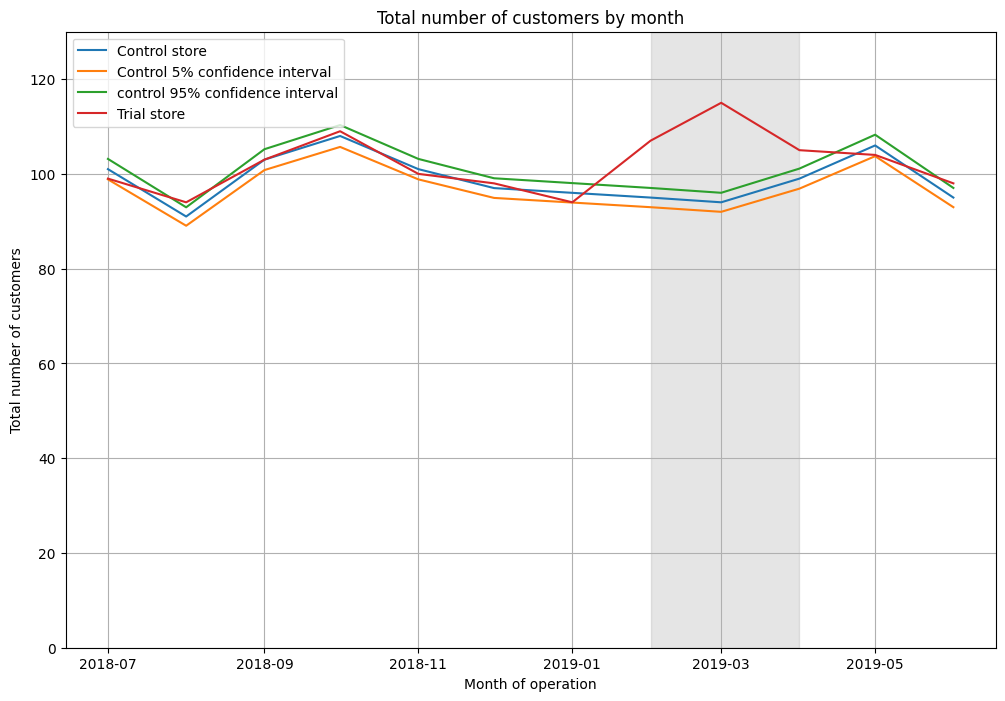

In [ ]:
# Lets plot the combineCustomers
plt.figure(figsize=(12,8))
plt.plot(combineCustomers)

plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')

plt.legend(['Control store','Control 5% confidence interval','control 95% confidence interval','Trial store'],loc= 2)

plt.ylim((0,130))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color ='grey',alpha=0.2)

plt.grid()
plt.show()


It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 .

#### **3. Control store for Trial store 88**


In [ ]:
# calculating correlation and magnitude distance between trial store 88 and other stores
trial_store = 88

# for total sales
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)

# for nCustomers
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)

In [ ]:
# SCORE TOTAL SALES
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

# combined score  composed of correlation and magnitude
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
88.0   1.0        0.813636   0.548959     0.681297
       2.0       -0.067927   0.541212     0.236643
       3.0       -0.507847   0.458109    -0.024869
       4.0       -0.745566   0.484447    -0.130559
       5.0        0.190330   0.496409     0.343370

In [ ]:
# SCORE CUSTOMERS
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()

Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
88.0   1.0        0.305334   0.357143         0.331238
       2.0       -0.452379   0.285714        -0.083332
       3.0        0.522884   0.683673         0.603279
       4.0       -0.361503   0.577922         0.108210
       5.0       -0.025320   0.558442         0.266561

In [ ]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'
score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'
score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()


scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
88.0   178.0      0.650803         0.707828           0.679316
       14.0       0.646064         0.685774           0.665919
       134.0      0.775084         0.540154           0.657619
       237.0      0.451974         0.777235           0.614604
       187.0      0.616752         0.594560           0.605656

store 178 matches trial store 88 the most. so we can assume 178 as control store fot trial store 88.

**b. Check visualize the performance trial store 88 and selected control store 178**

In [ ]:
pastdata = preTrialData

# Categorize data into trial store = 86, control store = 14, 134, 237 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 178:
        store_type.append('Control Store 178')
    elif i == 14:
        store_type.append('Control Store 14')
    elif i == 134:
        store_type.append('Control Store 134')
    elif i == 237:
        store_type.append('Control Store 237')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

In [ ]:
# Monthly tot sales for trial store 88
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 178
controlSalesPlot178 = pastdata.loc[pastdata['store_type'] == 'Control Store 178', ['Transaction_Month', 'totSales']]
controlSalesPlot178.set_index('Transaction_Month', inplace = True)
controlSalesPlot178.rename(columns = {'totSales': 'Control Store 178'}, inplace = True)

# Monthly total sales for control store 14
controlSalesPlot14 = pastdata.loc[pastdata['store_type'] == 'Control Store 14', ['Transaction_Month', 'totSales']]
controlSalesPlot14.set_index('Transaction_Month', inplace = True)
controlSalesPlot14.rename(columns = {'totSales': 'Control Store 14'}, inplace = True)

# Monthly total sales for control store 134
controlSalesPlot134 = pastdata.loc[pastdata['store_type'] == 'Control Store 134', ['Transaction_Month', 'totSales']]
controlSalesPlot134.set_index('Transaction_Month', inplace = True)
controlSalesPlot134.rename(columns = {'totSales': 'Control Store 134'}, inplace = True)

# Monthly total sales for control store 237
controlSalesPlot237 = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'totSales']]
controlSalesPlot237.set_index('Transaction_Month', inplace = True)
controlSalesPlot237.rename(columns = {'totSales': 'Control Store 237'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot178, controlSalesPlot14, controlSalesPlot134,  controlSalesPlot237, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store 178,Control Store 14,Control Store 134,Control Store 237,Other Stores
Transaction_Month,,,,,,
2018-07-01,1310.0,952.0,46.9,419.20,1448.4,631.436078
2018-08-01,1323.8,915.5,46.8,432.65,1367.8,603.500000
2018-09-01,1423.0,954.4,47.5,463.80,1322.2,612.761176
2018-10-01,1352.4,962.6,42.0,473.40,1348.3,627.932157
2018-11-01,1382.8,975.6,47.6,467.60,1397.6,611.187059
2018-12-01,1325.2,947.2,34.4,413.40,1265.0,642.600000
2019-01-01,1266.4,837.2,18.0,384.20,1219.7,622.968627


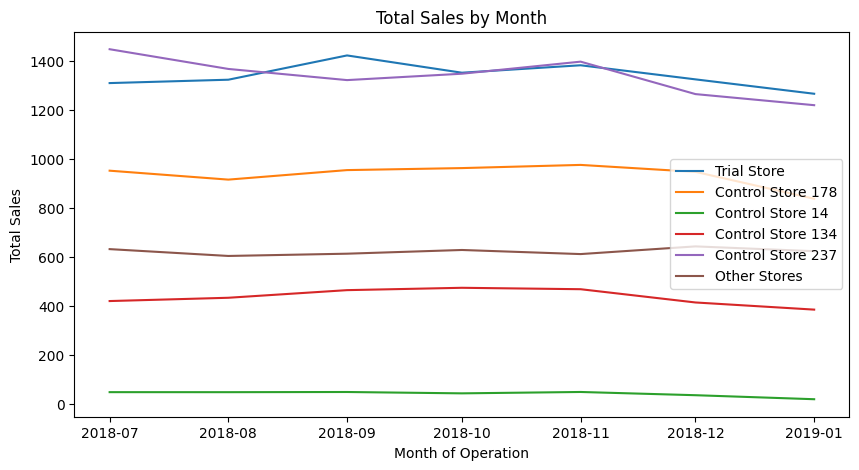

In [ ]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store 178','Control Store 14','Control Store 134', 'Control Store 237', 'Other Stores'], loc = 7)


After doing some visualisations, found that stores 178, 14 and 134 do not match trial store. store 237 macth trial store better. so set store 237 as control store.

In [ ]:
# Monthly tot sales for trial store 88
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 237
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,1310.0,1448.4,631.436078
2018-08-01,1323.8,1367.8,603.500000
2018-09-01,1423.0,1322.2,612.761176
2018-10-01,1352.4,1348.3,627.932157
2018-11-01,1382.8,1397.6,611.187059
2018-12-01,1325.2,1265.0,642.600000
2019-01-01,1266.4,1219.7,622.968627


In [ ]:
# Visualize 'nCustomers'
# monthly total customer for trial store 88
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 237
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,129,128,71.941176
2018-08-01,131,135,71.654902
2018-09-01,124,126,69.686275
2018-10-01,123,123,71.156863
2018-11-01,130,132,69.976471
2018-12-01,126,124,73.180392
2019-01-01,117,117,70.882353


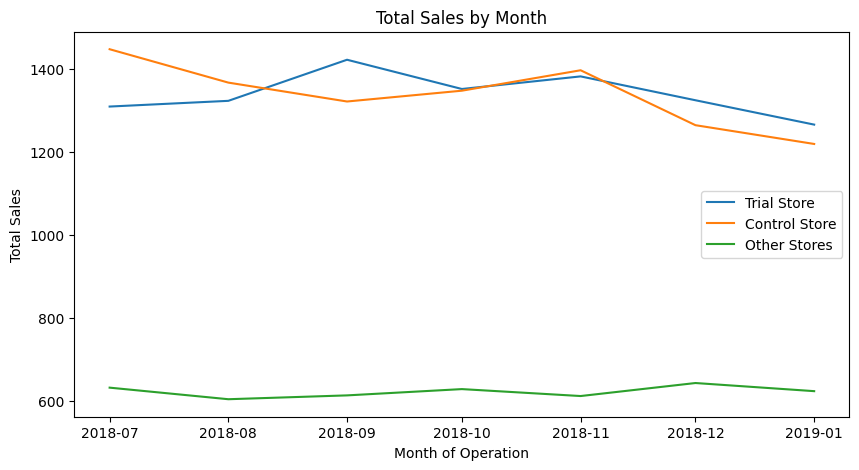

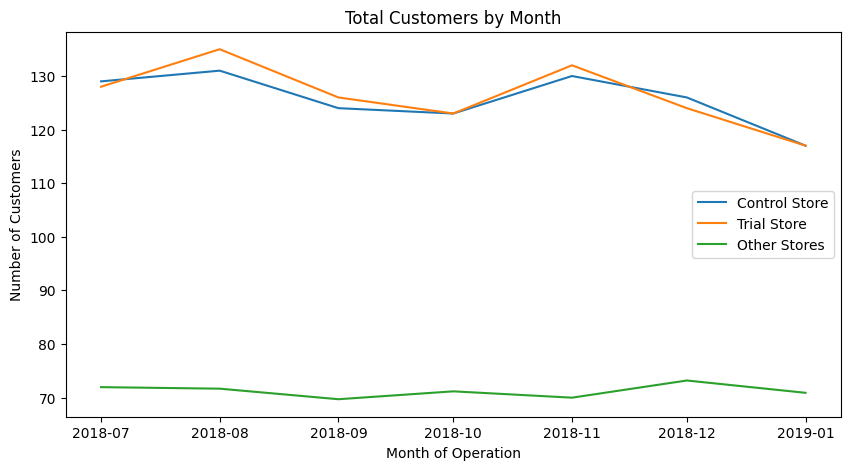

In [ ]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)


**c. Assesmen for Trial Store 88**

In [ ]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store
# Let's call this variable 'scalingFactorSales'

trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store 237', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

In [ ]:
# Create a new dataframe 'scaledControlSales' and reset index

scaledControlSales = measureOverTime

In [ ]:
# We only want control store i.e. store 237

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [ ]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales']*scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlSales
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01,926.040833
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01,783.919705
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,1015.980771
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01,965.301919
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01,900.200628


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH','controlSales']]
percentageDiff.reset_index(drop = True,inplace =True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] ==trial_store,'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff

,YEAR_MONTH,controlSales,trialSales
0,2018-07,926.040833,1310.00
1,2018-08,783.919705,1323.80
2,2018-09,1015.980771,1423.00
3,2018-10,965.301919,1352.40
4,2018-11,900.200628,1382.80
5,2018-12,851.124269,1325.20
6,2019-01,875.962916,1266.40
7,2019-02,892.588784,1370.20
8,2019-03,805.653521,1477.20
9,2019-04,845.916166,1439.40


In [ ]:
# Calculate percentage difference

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales)/percentageDiff.controlSales
percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,926.040833,1310.0,0.414624
1,2018-08,783.919705,1323.8,0.688693
2,2018-09,1015.980771,1423.0,0.400617
3,2018-10,965.301919,1352.4,0.401012
4,2018-11,900.200628,1382.8,0.536102


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

In [ ]:
# define the degrees of freedom (dof = 8-1 =7)
dof =7

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

In [ ]:
# Find the 95th percentile of the t distrobution with dof=7

t.isf(0.05,dof)

In [ ]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
TransactionMonth,
2018-07-01,926.040833
2018-08-01,783.919705
2018-09-01,1015.980771
2018-10-01,965.301919
2018-11-01,900.200628
2018-12-01,851.124269
2019-01-01,875.962916
2019-02-01,892.588784
2019-03-01,805.653521


In [ ]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,1310.00
2018-08-01,1323.80
2018-09-01,1423.00
2018-10-01,1352.40
2018-11-01,1382.80
2018-12-01,1325.20
2019-01-01,1266.40
2019-02-01,1370.20
2019-03-01,1477.20


In [ ]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)

In [ ]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,926.040833,726.542219,1125.539446,1310.00
2018-08-01,783.919705,615.038498,952.800913,1323.80
2018-09-01,1015.980771,797.106238,1234.855304,1423.00
2018-10-01,965.301919,757.345221,1173.258617,1352.40
2018-11-01,900.200628,706.268816,1094.132440,1382.80
2018-12-01,851.124269,667.765064,1034.483475,1325.20
2019-01-01,875.962916,687.252677,1064.673155,1266.40
2019-02-01,892.588784,700.296805,1084.880764,1370.20
2019-03-01,805.653521,632.090159,979.216883,1477.20


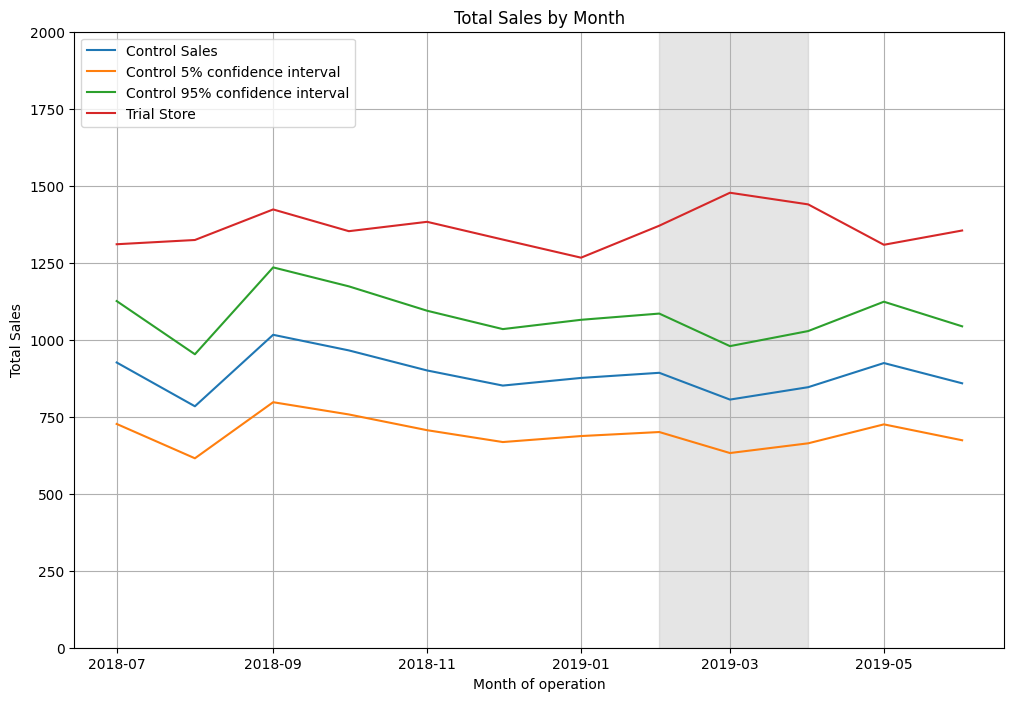

In [ ]:
# Lets plot the combineSales

plt.figure(figsize=(12,8))
plt.plot(combineSales)

plt.title('Total Sales by Month')
plt.xlabel('Month of operation')
plt.ylabel('Total Sales')

plt.legend(['Control Sales','Control 5% confidence interval','Control 95% confidence interval','Trial Store'],loc = 2)

plt.ylim((0,2000))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color='grey',alpha = 0.2)

plt.grid()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

In [ ]:
# Now let's move on to 'nCustomers'

trial_customers = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type'] == 'Control Store 237', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

In [ ]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01


In [ ]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
1793,155,2018-07,924.6,101,1.217822,2.032520,3.698400,2018-07-01,100.429379
1794,155,2018-08,782.7,91,1.307692,1.924370,3.417904,2018-08-01,90.485876
1795,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,102.418079
1796,155,2018-10,963.8,108,1.259259,2.000000,3.543382,2018-10-01,107.389831
1797,155,2018-11,898.8,101,1.316832,2.030075,3.328889,2018-11-01,100.429379


In [ ]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEAR_MONTH,controlCustomers,trialCustomers
0,2018-07,100.429379,129
1,2018-08,90.485876,131
2,2018-09,102.418079,124
3,2018-10,107.389831,123
4,2018-11,100.429379,130
5,2018-12,96.451977,126
6,2019-01,95.457627,117
7,2019-02,94.463277,124
8,2019-03,93.468927,134
9,2019-04,98.440678,128


In [ ]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,100.429379,129,0.284485
1,2018-08,90.485876,131,0.447740
2,2018-09,102.418079,124,0.210724
3,2018-10,107.389831,123,0.145360
4,2018-11,100.429379,130,0.294442
5,2018-12,96.451977,126,0.306350
6,2019-01,95.457627,117,0.225675
7,2019-02,94.463277,124,0.312679
8,2019-03,93.468927,134,0.433632
9,2019-04,98.440678,128,0.300275


In [ ]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

In [ ]:
# Define the degrees of freedom (dof = 8 - 1 = 7)

dof = 7

In [ ]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

In [ ]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

We can see that the t-value is larger than the 95th percentile value of the t-distribution for 3 month of trial period

In [ ]:
# visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,100.429379
2018-08-01,90.485876
2018-09-01,102.418079
2018-10-01,107.389831
2018-11-01,100.429379
2018-12-01,96.451977
2019-01-01,95.457627
2019-02-01,94.463277
2019-03-01,93.468927


In [ ]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,129
2018-08-01,131
2018-09-01,124
2018-10-01,123
2018-11-01,130
2018-12-01,126
2019-01-01,117
2019-02-01,124
2019-03-01,134


In [ ]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,100.429379,81.260636,119.598121,129
2018-08-01,90.485876,73.215028,107.756723,131
2018-09-01,102.418079,82.869757,121.966401,124
2018-10-01,107.389831,86.892561,127.887100,123
2018-11-01,100.429379,81.260636,119.598121,130
2018-12-01,96.451977,78.042393,114.861562,126
2019-01-01,95.457627,77.237832,113.677422,117
2019-02-01,94.463277,76.433271,112.493282,124
2019-03-01,93.468927,75.628711,111.309142,134


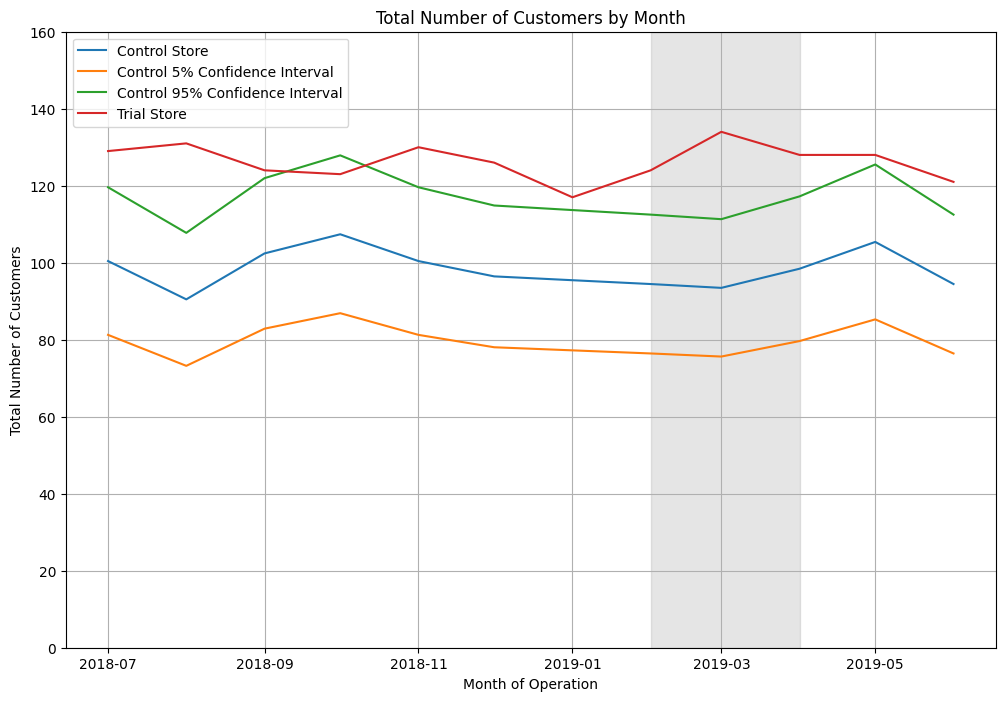

In [ ]:
# Let's plot the combineCustomers
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

plt.ylim((0, 160))

plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

plt.grid()
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

**we find that :**

* Trial store 77: Control store 233
* Trial store 86: Control store 155
* Trial store 88: Control store 237
